## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import sklearn.model_selection as skl
from random import sample
from itertools import chain
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import math

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
4480,00001210_003.png,No Finding,3,1210,67,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_001/images/00001210_003.png
27013,00007038_002.png,Effusion,2,7038,72,F,PA,2500,2048,0.168000,0.168000,NaN,/data/images_004/images/00007038_002.png
96305,00025344_000.png,No Finding,0,25344,19,M,PA,2806,2991,0.143000,0.143000,NaN,/data/images_011/images/00025344_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.head()

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df["Pneumonia_class"] = all_xray_df['Pneumonia'].map(lambda x: 'pneumonia' if x == 1.0 else 'no pneumonia')
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no pneumonia


## Create your training and testing data:

In [5]:
def create_splits(df):
    
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df['Pneumonia'])
    
    p_inds = train_data[train_data.Pneumonia==1].index.tolist()
    np_inds = train_data[train_data.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    p_inds = val_data[val_data.Pneumonia==1].index.tolist()
    np_inds = val_data[val_data.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,4*len(p_inds))
    val_data = val_data.loc[p_inds + np_sample]
    
    return train_data, val_data

train_df, val_df = create_splits(all_xray_df)

In [6]:
train_df['Pneumonia'].sum()/len(train_df)

0.5

In [7]:
val_df['Pneumonia'].sum()/len(val_df)

0.2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def my_image_augmentation():
    
    train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 10, 
                              shear_range = 0.2,
                              zoom_range= 0.15
                        )

    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    return train_idg, val_idg


def make_train_gen(train_idg,image_size):
    
    train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = image_size, 
                                         batch_size = 32
                                         )

    return train_gen


def make_val_gen(val_idg,image_size):
    
    val_gen = val_idg.flow_from_dataframe(dataframe=val_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = image_size, 
                                         batch_size = 128)
    return val_gen

In [9]:
IMG_SIZE = (224, 224)
train_idg, val_idg = my_image_augmentation()
train_gen = make_train_gen(train_idg,IMG_SIZE)
val_gen = make_val_gen(val_idg,IMG_SIZE)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

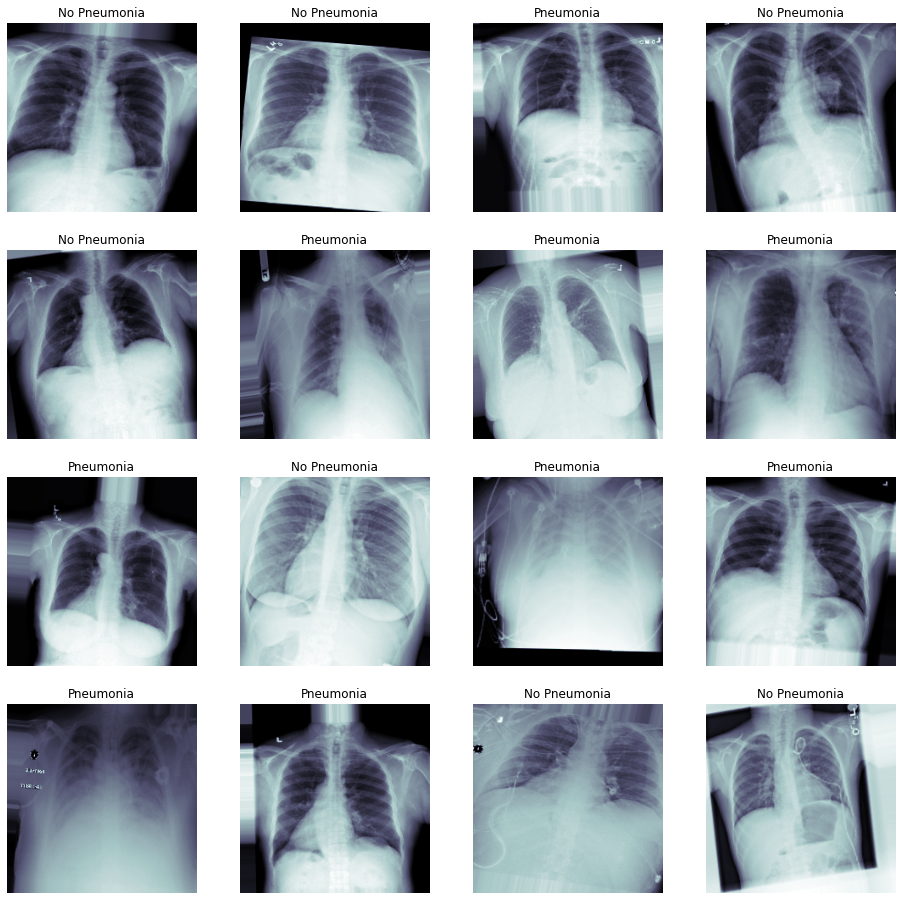

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
model = VGG16(include_top=True, weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [14]:
def build_my_model(model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    new_model = Sequential()
    new_model.add(model)
    new_model.add(Flatten())
    new_model.add(Dropout(0.5))
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(256, activation='relu')) 
    new_model.add(Dense(1, activation='sigmoid'))
    
    
    return new_model

my_model = build_my_model(vgg_model)
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [15]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                        monitor= 'val_loss', 
                        verbose=1, 
                        save_best_only=True, 
                        mode= 'auto', 
                        save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'auto', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [16]:
## train your model
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 50, 
                          callbacks = callbacks_list)

Epoch 1/50
72/72 [==============================] - 64s 888ms/step - loss: 0.7757 - binary_accuracy: 0.5218 - val_loss: 0.6237 - val_binary_accuracy: 0.7188

Epoch 00001: val_loss improved from inf to 0.62365, saving model to xray_class_my_model.best.hdf5
Epoch 2/50
72/72 [==============================] - 61s 850ms/step - loss: 0.7222 - binary_accuracy: 0.5170 - val_loss: 0.6794 - val_binary_accuracy: 0.5312

Epoch 00002: val_loss did not improve from 0.62365
Epoch 3/50
72/72 [==============================] - 61s 843ms/step - loss: 0.6970 - binary_accuracy: 0.5384 - val_loss: 0.6380 - val_binary_accuracy: 0.5938

Epoch 00003: val_loss did not improve from 0.62365
Epoch 4/50
72/72 [==============================] - 60s 835ms/step - loss: 0.6928 - binary_accuracy: 0.5502 - val_loss: 0.6127 - val_binary_accuracy: 0.6797

Epoch 00004: val_loss improved from 0.62365 to 0.61266, saving model to xray_class_my_model.best.hdf5
Epoch 5/50
72/72 [==============================] - 60s 839ms/step

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

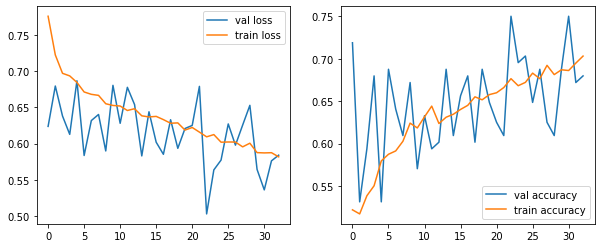

In [17]:
f = plt.figure()
f.set_figwidth(10)
f.add_subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.legend()

f.add_subplot(1, 2, 2)
plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
plt.plot(history.history['binary_accuracy'], label='train accuracy')
plt.legend()

plt.show()

In [18]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

128/128 [==============================] - 1s 9ms/step


In [19]:
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')    
    plt.show()

## what other performance statistics do you want to include here besides AUC? 

def plot_pr(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

    
# Also consider plotting the history of your model training:

def plot_history(history):
    return

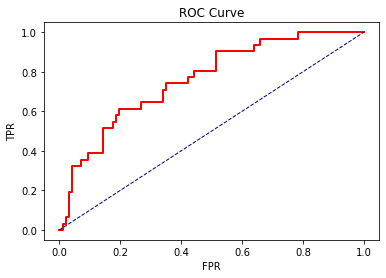

In [20]:
## plot figures
plot_auc(valY, pred_Y)


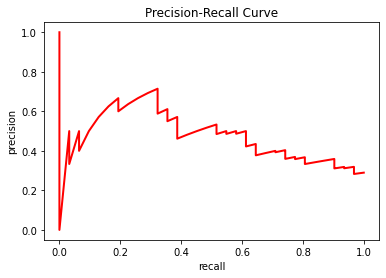

In [21]:
plot_pr(valY, pred_Y)

Text(0.5, 1.0, 'Precision/Recall by threshold')

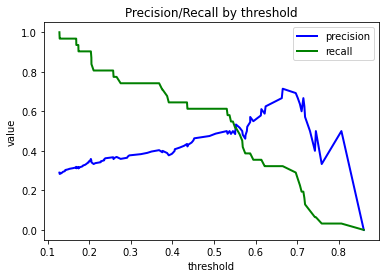

In [22]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y, pos_label=1)
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('Precision/Recall by threshold')

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


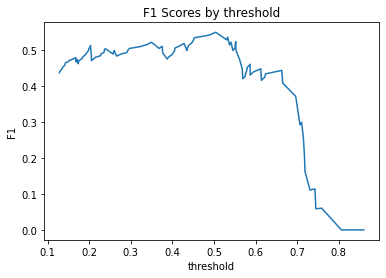

In [27]:
th = 0.55

def f1(threshold):
    for i,t in enumerate(thresholds):
        if t > threshold:
            f1score = calc_f1(precision[i], recall[i])
            if not math.isnan(f1score):
                return f1score
            else: 
                return 0
    return 0

f1scores = [f1(t) for t in thresholds]
plt.plot(thresholds, f1scores)
plt.title('F1 Scores by threshold')
plt.xlabel('threshold')
plt.ylabel('F1')
plt.show()

In [35]:
YOUR_THRESHOLD = 0.55
testY = valY

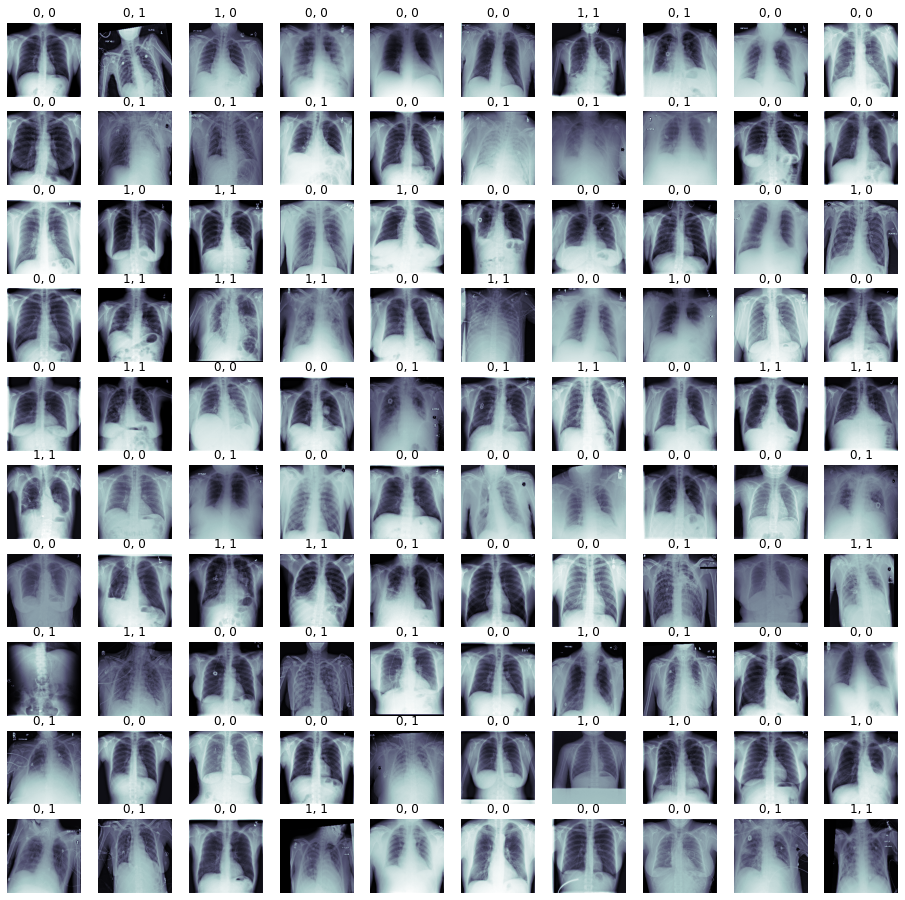

In [34]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [30]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)